In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import cm, colors
import cv2
import matplotlib.pyplot as plt

# Sparse PCA

In [ ]:
import numpy as np
import cupy as cp

class SparsePCA():
    """
    Class object that contains all code necessary to run the sparse PCA. The main method that calls the other methods is
    self.fit(). The logic is:
    1. Take the data matrix and compute the first principal component without constraints. (method: run_regular_pca_())
    2. Iteratively sparsify the component using gradient descent (method: sparsify_w())
    3. Remove the variance of the found component from the data matrix.

    Then repeat 1.-3. until all desired components are found.
    """
    def __init__(self, n_components, alpha=100, verbose=False):
        self.n_components = n_components
        self.alpha = alpha
        self.verbose = verbose
        self.explained_variance = None

    def run_regular_pca_(self, X):
        """
        Initializes a principal component without sparsity constraint
        Args:
            X: data matrix of shape (n, k)

        Returns: Principal component of shape (k)

        """

        u, s, vt = cp.linalg.svd(X)
        v = cp.squeeze(vt[0, :])
        if self.verbose:
            print(v @ cp.cov(X.T) @ v)
            print("l1 norm of unconstrained component:", cp.linalg.norm(v, 1))
        return v

    ### Methods for gradient calculation. Don't need to be called outside thise file!
    def abs(self, w):
        return w * cp.tanh(self.alpha * w)

    def abs_prime(self, w):
        diag = cp.tanh(self.alpha * w) + self.alpha * w * (1 - cp.tanh(self.alpha * w) ** 2)
        return diag

    def u1(self, X, w):
        return w @ cp.cov(X.T) @ w

    def u2(self, w):
        return - cp.sum(self.abs(w))

    def v1(self, w):
        return cp.linalg.norm(w) ** 2

    def v2(self, w):
        return cp.linalg.norm(w) ** 2

    def u1_prime(self, X, w):
        u_prime = 2 * w.T @ cp.cov(X.T)
        return u_prime

    def u2_prime(self, w):
        return - self.abs_prime(w)

    def v1_prime(self, w):
        return 2 * w

    def v2_prime(self, w):
        return 2 * w

    def compute_first_grad(self, X, w):
        enum = self.u1_prime(X, w) * self.v1(w) - self.u1(X, w) * self.v1_prime(w)
        denom = self.v1(w) ** 2
        return enum / denom

    def compute_reg_grad(self, w):
        enum = self.u2_prime(w) * self.v2(w) - self.u2(w) * self.v2_prime(w)
        denom = self.v2(w) ** 2
        grad = enum / denom
        return grad

    def compute_grad(self, X, w, lambd):
        grad = self.compute_first_grad(X, w) + lambd * self.compute_reg_grad(w)
        # Orthogonalize
        grad = grad - (cp.dot(grad, w) / cp.dot(w, w)) * w
        return grad

    def compute_loss(self, X, w, lambd):
        return self.u1(X, w) / self.v1(w) + lambd * self.u2(w) / self.v2(w)

    def sparsify_w(self, X, w, lambd, lr, steps):
        """
        Iteratively sparsifies a principal component w
        Args:
            X: Data matrix
            w: Starting point of the optimization. Should be an unconstrained PC
            lambd: hyperparameter
            lr: Learning rate
            steps: Number of steps of iteration

        Returns: The sparse principal component of shape (k)

        """
        if self.verbose == True:
            print("starting loss:", self.compute_loss(X, w, lambd))
        for step in range(steps):
            grad = self.compute_grad(X, w, lambd)
            w += lr * grad
            w = w / cp.linalg.norm(w)
            if step % 1000 == 0 and self.verbose == True:
                print("step:", step)
                print("grad norm:", cp.linalg.norm(grad))
                print("loss:", self.compute_loss(X, w, lambd))
                print("var loss:", self.u1(X, w) / self.v1(w), "reg loss:", lambd * self.u2(w) / self.v2(w))
                print()
        return w

    def find_component(self, X, lambd, lr, steps):
        """
        Finds the sparse principal component for a data matrix
        Args:
            X: Data matrix
            lambd: hyperparameter
            lr: Learning rate
            steps: Number of steps

        Returns: The sparse principal component of shape (k)

        """
        w = self.run_regular_pca_(X)
        w_out = self.sparsify_w(X, w, lambd, lr, steps)
        return w_out

    def remove_variance(self, X, w):
        """
        Remove the component variance from the data to prepare matrix to find the next component
        Args:
            X: Data matrix used to compute w
            w: First principal component of matrix X

        Returns: The data matrix with variance removed. Shape is same as X

        """
        X = X - X @ cp.outer(w, w)
        return X

    def fit(self, X, lambdas, lr=1e-6, steps=1000):
        """
        Finds all sparse principal components in one run.
        Args:
            X: Data matrix
            lambdas: Int or List of length self.n_components containing where entry i is hyperparameter for component i
            lr: Learning rate
            steps: Number of steps to be used

        Returns: Matrix where the i-th column contains the i-th sparse PC

        """
        # Keep track of the original X
        X_original = cp.copy(X)
        if not isinstance(lambdas, list):
            lambdas = self.n_components * [lambdas]
        # Initialize component matrix
        W = cp.zeros((X.shape[1], self.n_components))
        # Loop over number of desired components
        for component_id in range(self.n_components):
            print("Computing component", component_id, "...")
            w = self.find_component(X, lambdas[component_id], lr, steps)
            W[:, component_id] = w
            # Remove the variance of the found component from the data to find the next one
            X = self.remove_variance(X, w)
        # Compute explained variance
        self.compute_explained_variance(X_original, W)
        return W

    def compute_explained_variance(self, X, W):
        """
        Computes the explained variance (done automatically after fitting)
        Args:
            X: Data matrix
            W: Matrix containing the principal components (n_features, n_components)

        Returns: nd.array where entry i is the ratio of explained variance of component i

        """
        self.explained_variance = cp.diag(W.T @ cp.cov(X.T) @ W) / cp.trace(cp.cov(X.T))
        return None

In [2]:
import cupy as cp

class Robust_Sparse_PCA:

    def __init__(self, imax=1000, fthres=1e-7, verbose=False):
        self.imax = imax  # Maximum number of iterations
        self.fthres = fthres  # Convergence threshold
        self.verbose = verbose  # Print progress during iterations

    def shrink(self, X, tau):
        Y = cp.abs(X) - tau
        return cp.sign(X) * cp.maximum(Y, cp.zeros_like(Y))

    def SVT(self, X, tau):
        U, S, VT = cp.linalg.svd(X, full_matrices=0)
        out = U @ cp.diag(self.shrink(S, tau)) @ VT
        return out

    def fit(self, X):
        m, n = X.shape  # Store matrix dimensions
        mu = m * n / (4 * cp.sum(cp.abs(X.reshape(-1))))  # Calculate mu
        lambd = 1 / cp.sqrt(cp.max(cp.asarray([m, n])))  # Calculate lambda
        thres = self.fthres * cp.linalg.norm(X)  # Determine threshold (tolerance)

        # Initialize matrices L, S, and Y
        L = cp.zeros_like(X)
        S = cp.zeros_like(X)
        Y = cp.zeros_like(X)

        count = 0
        # Continue iterating while X ≈ L + S is above threshold or maximum number of iterations has been reached
        while (cp.linalg.norm(X - L - S) > thres) and (count < self.imax):
            if self.verbose:
                print(f'{cp.round(thres / cp.linalg.norm(X - L - S), 3)}% ...   ({count}/{self.imax})')

            # Update L, S, and Y
            L = self.SVT(X - S + 1 / mu * Y, 1 / mu)
            S = self.shrink(X - L + 1 / mu * Y, lambd / mu)
            Y = Y + mu * (X - L - S)
            count += 1

        # Print number of iterations required
        if self.verbose:
            if count == self.imax:
                print(f'No convergence after {count} iterations')
            else:
                print(f'Solution found after {count} iterations')

        self.L_ = L
        self.S_ = S

        return self


# Noise Models

In [3]:

def to_std_float(img):
    #Converts img to 0 to 1 float to avoid wrapping that occurs with uint8
    img.astype(np.float16, copy = False)
    img = np.multiply(img, (1/255))

    return img

def to_std_uint8(img):
    # Properly handles the conversion to uint8
    img = cv2.convertScaleAbs(img, alpha = (255/1))

    return img

def display_result(img, title='Image', show=True):
    fig, axs = plt.subplots(figsize = (7, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title(title)  # Set the title of the plot
    if show:
        plt.tight_layout()
        plt.show()  # Show the plot

In [4]:
def salt_n_pepper(img, pad = 101, show = 1):
    # Convert img1 to 0 to 1 float to avoid wrapping that occurs with uint8
    img = to_std_float(img)

    noise = np.random.randint(pad, size = (img.shape[0], img.shape[1], 1))


    img = np.where(noise == 0, 0, img)
    img = np.where(noise == (pad-1), 1, img)

    # Properly handles the conversion from float16 back to uint8
    img = to_std_uint8(img)

#     display_result(img, 'Image with Salt & Pepper Noise', show)

    return img

def add_gaussian_noise(img, mean=0, std=0.1, show=True):
    # Convert img to 0 to 1 float to avoid wrapping that occurs with uint8
    img = to_std_float(img)

    noise = np.random.normal(mean, std, size=(img.shape[0], img.shape[1], img.shape[2]))

    img_with_noise = img + noise

    # Clip the image to the valid range of [0, 1]
    img_with_noise = np.clip(img_with_noise, 0, 1)

    # Properly handles the conversion from float back to uint8
    img_with_noise = to_std_uint8(img_with_noise)

#     display_result(img_with_noise, 'Image with Gaussian Noise', show)

    return img_with_noise


# Cifar-10

In [5]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 71.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.9 MB/s eta 0:00:00


In [7]:
import os
import cv2
import py7zr
path = '/kaggle/input/cifar-10/train.7z'
extract_path = '/kaggle/working/cifar-10/train'

def unzip_7z_file(file_path, destination_path):
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(path=destination_path)
unzip_7z_file(path, extract_path)

In [8]:
import cv2
list_img = os.listdir('/kaggle/working/cifar-10/train/train')
# list_img
num_images = len(list_img)
image_size = 28  # Set the desired size for the flattened images

r_matrix = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
g_matrix = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
b_matrix = np.zeros((num_images, image_size * image_size), dtype=np.uint8)

noise_r = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
noise_g = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
noise_b = np.zeros((num_images, image_size * image_size), dtype=np.uint8)

for i, img in enumerate(list_img):
    img_path = os.path.join('/kaggle/working/cifar-10/train/train', img)
    
    img = cv2.imread(img_path)
#     noise_img = add_gaussian_noise(img)
    noise_img = salt_n_pepper(img)
    
    b, g, r = cv2.split(img)
    b = cv2.resize(b, (image_size, image_size))
    flattened_b = b.flatten()
    b_matrix[i] = flattened_b
    
    g = cv2.resize(g, (image_size, image_size))
    flattened_g = g.flatten()
    g_matrix[i] = flattened_g
    
    r = cv2.resize(r, (image_size, image_size))
    flattened_r = r.flatten()
    r_matrix[i] = flattened_r
#     print(img.shape)
    nb, ng, nr = cv2.split(noise_img)
    nb = cv2.resize(nb, (image_size, image_size))
    flattened_nb = nb.flatten()
    noise_b[i] = flattened_nb
    
    ng = cv2.resize(ng, (image_size, image_size))
    flattened_ng = ng.flatten()
    noise_g[i] = flattened_ng
    
    nr = cv2.resize(nr, (image_size, image_size))
    flattened_nr = nr.flatten()
    noise_r[i] = flattened_nr

In [28]:
r_matrix = r_matrix / np.max(r_matrix)
g_matrix = g_matrix / np.max(g_matrix)
b_matrix = b_matrix / np.max(b_matrix)

noise_r = noise_r / np.max(noise_r)
noise_g = noise_g / np.max(noise_g)
noise_b = noise_b / np.max(noise_b)

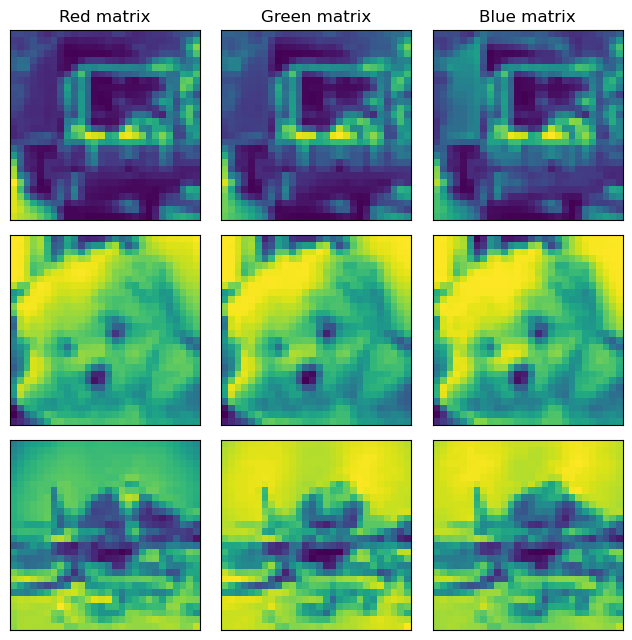

In [29]:
# For each of the first 10 digits of the dataset: plot X, nX, L & S
fig, axs = plt.subplots(3, 3, figsize = (6.5, 6.5))
# cmap = 'Greys'

for k in range(3):

    axs[k,0].imshow(r_matrix[k+50].reshape(28, 28))
    axs[k,1].imshow(g_matrix[k+50].reshape(28, 28))
    axs[k,2].imshow(b_matrix[k+50].reshape(28, 28))
#     axs[k,3].imshow(unsharp_mask(L[k].reshape(32, 32)))
    
    for i in range(3):
        axs[k,i].set_xticks([])
        axs[k,i].set_yticks([])

    if k == 0:
        axs[k,0].set_title('Red matrix', size = 12)
        axs[k,1].set_title('Green matrix', size = 12)
        axs[k,2].set_title('Blue matrix', size = 12)

plt.tight_layout()
plt.savefig('RPCA_digits_greycmap.jpeg', dpi = 400)
plt.show()

In [30]:
# Perform robust PCA on the digits-matrix
# Example usage
noise_b_gpu, noise_g_gpu, noise_r_gpu = cp.asarray(noise_b), cp.asarray(noise_g), cp.asarray(noise_r)

rpcadm = Robust_Sparse_PCA(imax=1000, fthres=1e-7, verbose=True)

print('Computing Sparse PCA for blue matrix...')
rpcadm.fit(noise_b_gpu)
L_b, S_b = cp.asnumpy(rpcadm.L_), cp.asnumpy(rpcadm.S_)
print('Done. Computing Sparse PCA for green matrix...')

rpcadm.fit(noise_g_gpu)
L_g, S_g = cp.asnumpy(rpcadm.L_), cp.asnumpy(rpcadm.S_)
print('Done. Computing Sparse PCA for red matrix...')

rpcadm.fit(noise_r_gpu)# Provide your input data matrix X
L_r, S_r = cp.asnumpy(rpcadm.L_), cp.asnumpy(rpcadm.S_)# Obtained low-rank component
print('Done')
  # Obtained sparse component

Computing Sparse PCA for blue matrix...
0.0% ...   (0/1000)
0.0% ...   (1/1000)
0.0% ...   (2/1000)
0.0% ...   (3/1000)
0.0% ...   (4/1000)
0.0% ...   (5/1000)
0.0% ...   (6/1000)
0.0% ...   (7/1000)
0.0% ...   (8/1000)
0.0% ...   (9/1000)
0.0% ...   (10/1000)
0.0% ...   (11/1000)
0.0% ...   (12/1000)
0.0% ...   (13/1000)
0.0% ...   (14/1000)
0.0% ...   (15/1000)
0.0% ...   (16/1000)
0.0% ...   (17/1000)
0.0% ...   (18/1000)
0.0% ...   (19/1000)
0.0% ...   (20/1000)
0.0% ...   (21/1000)
0.0% ...   (22/1000)
0.0% ...   (23/1000)
0.0% ...   (24/1000)
0.0% ...   (25/1000)
0.0% ...   (26/1000)
0.0% ...   (27/1000)
0.0% ...   (28/1000)
0.0% ...   (29/1000)
0.0% ...   (30/1000)
0.0% ...   (31/1000)
0.0% ...   (32/1000)
0.0% ...   (33/1000)
0.0% ...   (34/1000)
0.0% ...   (35/1000)
0.0% ...   (36/1000)
0.0% ...   (37/1000)
0.0% ...   (38/1000)
0.0% ...   (39/1000)
0.0% ...   (40/1000)
0.0% ...   (41/1000)
0.0% ...   (42/1000)
0.0% ...   (43/1000)
0.0% ...   (44/1000)
0.001% ...   (45/1000)
0.

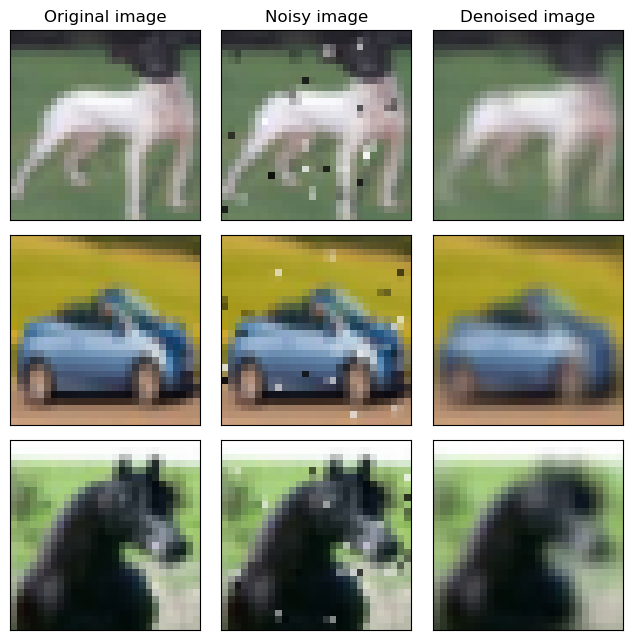

In [31]:
fig, axs = plt.subplots(3, 3, figsize = (6.5, 6.5))

for k in range(3):
    red_image = r_matrix[k+5].reshape(image_size,image_size)
    green_image = g_matrix[k+5].reshape(image_size ,image_size)
    blue_image = b_matrix[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    rgb_image = np.stack((red_image, green_image, blue_image), axis=2)
    rgb_image_scaled = (rgb_image * 255).astype(np.uint8)
    axs[k, 0].imshow(rgb_image_scaled)
    
    noise_red = noise_r[k+5].reshape(image_size,image_size)
    noise_green = noise_g[k+5].reshape(image_size ,image_size)
    noise_blue = noise_b[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    rgb_noise_image = np.stack((noise_red, noise_green, noise_blue), axis=2)
    rgb_noise_image_scaled = (rgb_noise_image * 255).astype(np.uint8)
    axs[k, 1].imshow(rgb_noise_image_scaled)
    
    Lr_image = L_r[k+5].reshape(image_size,image_size)
    Lg_image = L_g[k+5].reshape(image_size ,image_size)
    Lb_image = L_b[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    L_image = np.stack((Lr_image, Lg_image, Lb_image), axis=2)
    L_image_scaled = (L_image * 255).astype(np.uint8)
    axs[k, 2].imshow(L_image_scaled)

    for i in range(3):
        axs[k,i].set_xticks([])
        axs[k,i].set_yticks([])
        
    if k == 0:
        axs[k,0].set_title('Original image', size = 12)
        axs[k,1].set_title('Noisy image', size = 12)
        axs[k,2].set_title('Denoised image', size = 12)
#     axs[i,1].set_yticks([])
plt.tight_layout()
plt.savefig('RSPCA_Cifar10_Gaussian.jpeg', dpi = 400)
plt.show()

# PCA


In [20]:
import numpy as np
from sklearn.decomposition import PCA, SparsePCA
import matplotlib.pyplot as plt

In [16]:
import cv2
list_img = os.listdir('/kaggle/working/cifar-10/train/train')
# list_img
num_images = len(list_img)
image_size = 28  # Set the desired size for the flattened images

r_matrix = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
g_matrix = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
b_matrix = np.zeros((num_images, image_size * image_size), dtype=np.uint8)

noise_r = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
noise_g = np.zeros((num_images, image_size * image_size), dtype=np.uint8)
noise_b = np.zeros((num_images, image_size * image_size), dtype=np.uint8)

for i, img in enumerate(list_img):
    img_path = os.path.join('/kaggle/working/cifar-10/train/train', img)
    
    img = cv2.imread(img_path)
    noise_img = add_gaussian_noise(img)
#     noise_img = salt_n_pepper(img)
    
    b, g, r = cv2.split(img)
    b = cv2.resize(b, (image_size, image_size))
    flattened_b = b.flatten()
    b_matrix[i] = flattened_b
    
    g = cv2.resize(g, (image_size, image_size))
    flattened_g = g.flatten()
    g_matrix[i] = flattened_g
    
    r = cv2.resize(r, (image_size, image_size))
    flattened_r = r.flatten()
    r_matrix[i] = flattened_r
#     print(img.shape)
    nb, ng, nr = cv2.split(noise_img)
    nb = cv2.resize(nb, (image_size, image_size))
    flattened_nb = nb.flatten()
    noise_b[i] = flattened_nb
    
    ng = cv2.resize(ng, (image_size, image_size))
    flattened_ng = ng.flatten()
    noise_g[i] = flattened_ng
    
    nr = cv2.resize(nr, (image_size, image_size))
    flattened_nr = nr.flatten()
    noise_r[i] = flattened_nr

In [17]:
r_matrix = r_matrix / np.max(r_matrix)
g_matrix = g_matrix / np.max(g_matrix)
b_matrix = b_matrix / np.max(b_matrix)

noise_r = noise_r / np.max(noise_r)
noise_g = noise_g / np.max(noise_g)
noise_b = noise_b / np.max(noise_b)

In [18]:
# Apply PCA to the image data
pca = PCA(n_components=50)  # choose 50 principal components

noise_r_pca = pca.fit_transform(noise_r) # Reconstruct the images using the principal components
noise_r_reconstructed = pca.inverse_transform(noise_r_pca) # Reshape the flattened images to their original dimensions
# noise_r_reconstructed = noise_r_reconstructed.reshape(-1, img_size, img_size)

noise_g_pca = pca.fit_transform(noise_g)
noise_g_reconstructed = pca.inverse_transform(noise_g_pca)
# noise_g_reconstructed = noise_g_reconstructed.reshape(-1, img_size, img_size)

noise_b_pca = pca.fit_transform(noise_b)
noise_b_reconstructed = pca.inverse_transform(noise_b_pca)
# noise_b_reconstructed = noise_b_reconstructed.reshape(-1, img_size, img_size)

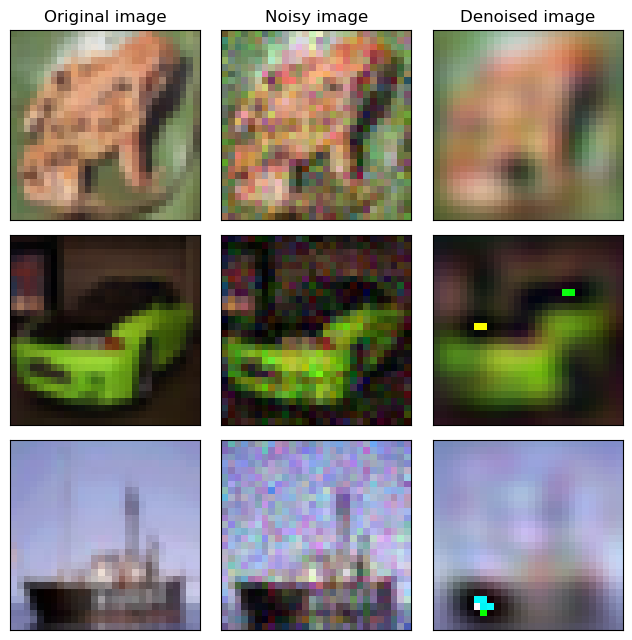

In [19]:
fig, axs = plt.subplots(3, 3, figsize = (6.5, 6.5))

for k in range(3):
    red_image = r_matrix[k+5].reshape(image_size,image_size)
    green_image = g_matrix[k+5].reshape(image_size ,image_size)
    blue_image = b_matrix[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    rgb_image = np.stack((red_image, green_image, blue_image), axis=2)
    rgb_image_scaled = (rgb_image * 255).astype(np.uint8)
    axs[k, 0].imshow(rgb_image_scaled)
    
    noise_red = noise_r[k+5].reshape(image_size,image_size)
    noise_green = noise_g[k+5].reshape(image_size ,image_size)
    noise_blue = noise_b[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    rgb_noise_image = np.stack((noise_red, noise_green, noise_blue), axis=2)
    rgb_noise_image_scaled = (rgb_noise_image * 255).astype(np.uint8)
    axs[k, 1].imshow(rgb_noise_image_scaled)
    
    Lr_image = noise_r_reconstructed[k+5].reshape(image_size,image_size)
    Lg_image = noise_g_reconstructed[k+5].reshape(image_size ,image_size)
    Lb_image = noise_b_reconstructed[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    L_image = np.stack((Lr_image, Lg_image, Lb_image), axis=2)
    L_image_scaled = (L_image * 255).astype(np.uint8)
    axs[k, 2].imshow(L_image_scaled)

    for i in range(3):
        axs[k,i].set_xticks([])
        axs[k,i].set_yticks([])
        
    if k == 0:
        axs[k,0].set_title('Original image', size = 12)
        axs[k,1].set_title('Noisy image', size = 12)
        axs[k,2].set_title('Denoised image', size = 12)
#     axs[i,1].set_yticks([])
plt.tight_layout()
plt.savefig('PCA_Cifar10_Gaussian.jpeg', dpi = 400)
plt.show()

# Sparse PCA

In [ ]:
# Apply PCA to the image data
spca = SparsePCA(n_components=50)  # choose 50 principal components

noise_r_pca = spca.fit_transform(noise_r) # Reconstruct the images using the principal components
noise_r_reconstructed = spca.inverse_transform(noise_r_pca) # Reshape the flattened images to their original dimensions
# noise_r_reconstructed = noise_r_reconstructed.reshape(-1, img_size, img_size)

noise_g_pca = spca.fit_transform(noise_g)
noise_g_reconstructed = spca.inverse_transform(noise_g_pca)
# noise_g_reconstructed = noise_g_reconstructed.reshape(-1, img_size, img_size)

noise_b_pca = spca.fit_transform(noise_b)
noise_b_reconstructed = spca.inverse_transform(noise_b_pca)
# noise_b_reconstructed = noise_b_reconstructed.reshape(-1, img_size, img_size)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (6.5, 6.5))

for k in range(3):
    red_image = r_matrix[k+5].reshape(image_size,image_size)
    green_image = g_matrix[k+5].reshape(image_size ,image_size)
    blue_image = b_matrix[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    rgb_image = np.stack((red_image, green_image, blue_image), axis=2)
    rgb_image_scaled = (rgb_image * 255).astype(np.uint8)
    axs[k, 0].imshow(rgb_image_scaled)
    
    noise_red = noise_r[k+5].reshape(image_size,image_size)
    noise_green = noise_g[k+5].reshape(image_size ,image_size)
    noise_blue = noise_b[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    rgb_noise_image = np.stack((noise_red, noise_green, noise_blue), axis=2)
    rgb_noise_image_scaled = (rgb_noise_image * 255).astype(np.uint8)
    axs[k, 1].imshow(rgb_noise_image_scaled)
    
    Lr_image = noise_r_reconstructed[k+5].reshape(image_size,image_size)
    Lg_image = noise_g_reconstructed[k+5].reshape(image_size ,image_size)
    Lb_image = noise_b_reconstructed[k+5].reshape(image_size, image_size)
    # Stack the individual color channels to create an RGB image
    L_image = np.stack((Lr_image, Lg_image, Lb_image), axis=2)
    L_image_scaled = (L_image * 255).astype(np.uint8)
    axs[k, 2].imshow(L_image_scaled)

    for i in range(3):
        axs[k,i].set_xticks([])
        axs[k,i].set_yticks([])
        
    if k == 0:
        axs[k,0].set_title('Original image', size = 12)
        axs[k,1].set_title('Noisy image', size = 12)
        axs[k,2].set_title('Denoised image', size = 12)
#     axs[i,1].set_yticks([])
plt.tight_layout()
plt.savefig('SPCA_Cifar10_Gaussian.jpeg', dpi = 400)
plt.show()